In [42]:
# Import Required Libraries
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image


In [49]:
#Load and Preprocess the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use y_test as test labels
x_test_label = y_test.squeeze()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


In [29]:
class Encoder(tf.keras.Model):  
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')
        self.conv2 = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')
        self.flatten = layers.Flatten()
        self.dense_mu = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.flatten(x)
        mu = self.dense_mu(x)
        log_var = self.dense_log_var(x)
        return mu, log_var


Model: "encoder_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          multiple                  896       
                                                                 
 conv2d_15 (Conv2D)          multiple                  18496     
                                                                 
 flatten_7 (Flatten)         multiple                  0         
                                                                 
 dense_19 (Dense)            multiple                  262208    
                                                                 
 dense_20 (Dense)            multiple                  262208    
                                                                 
Total params: 543,808
Trainable params: 543,808
Non-trainable params: 0
_________________________________________________________________


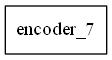

In [32]:
# Define input dimension
input_shape = (32, 32, 3)

# Create an encoder instance
encoder = Encoder(latent_dim)

# Building the model explicitly
encoder.build(input_shape=(None, *input_shape)) 

# summary()
encoder.summary()
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)



In [33]:
class Decoder(tf.keras.Model):  
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(8 * 8 * 64, activation='relu')
        self.reshape = layers.Reshape((8, 8, 64))
        self.convT1 = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')
        self.convT2 = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')
        self.convT3 = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.convT1(z)
        z = self.convT2(z)
        return self.convT3(z)



Model: "decoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            multiple                  266240    
                                                                 
 reshape_4 (Reshape)         multiple                  0         
                                                                 
 conv2d_transpose_12 (Conv2D  multiple                 36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  multiple                 18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  multiple                 867       
 Transpose)                                                      
                                                         

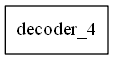

In [34]:
# Size of latent space
latent_dim = 64  

# Create a decoder instance
decoder = Decoder(latent_dim)

# Building the model explicitly
decoder.build(input_shape=(None, latent_dim)) 

# summary()
decoder.summary()
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)


In [39]:
#Define the VAE Model
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def call(self, inputs):
        mu, log_var = self.encoder(inputs)
        batch_size = tf.shape(inputs)[0]
        z = self.reparameterize(mu, log_var, batch_size)
        return self.decoder(z)

    def reparameterize(self, mu, log_var, batch_size):
        eps = tf.random.normal(shape=(batch_size, tf.shape(mu)[1]))
        return eps * tf.exp(log_var * 0.5) + mu

    def vae_loss(self, x, x_recon, mu, log_var):
        # Reconstruction loss
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_recon), axis=[1, 2, 3]))
        # KL divergence
        kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        return recon_loss + kl_loss


Model: "vae_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_11 (Encoder)        multiple                  543808    
                                                                 
 decoder_8 (Decoder)         multiple                  322499    
                                                                 
Total params: 866,307
Trainable params: 866,307
Non-trainable params: 0
_________________________________________________________________


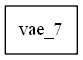

In [43]:
# Define input dimension
input_shape = (32, 32, 3)

# Create a VAE body
vae = VAE(latent_dim)

# Building the model explicitly
vae.build(input_shape=(None, *input_shape))  # None pour la dimension du batch

# summary()
vae.summary()
plot_model(vae, to_file='vae.png', show_shapes=True, show_layer_names=True)

# Image display in notebook
display(Image(filename='vae.png'))


In [23]:
#Training Setup
latent_dim = 64
epochs = 10
vae = VAE(latent_dim)
optimizer = tf.keras.optimizers.Adam()

# Ensure model is built by running a dummy forward pass
_ = vae(tf.random.normal([1, 32, 32, 3]))

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        mu, log_var = vae.encoder(x)
        x_recon = vae(x)
        loss = vae.vae_loss(x, x_recon, mu, log_var)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss


In [24]:
# Training loop
batch_size = 32  
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1024).batch(batch_size)

for epoch in range(epochs):
    for step, x_batch in enumerate(train_dataset):
        loss = train_step(x_batch)
        if step % 100 == 0:
            print(f"Epoch: {epoch}, Step: {step}, Loss: {loss.numpy()}")


Epoch: 0, Step: 0, Loss: 212.8167266845703
Epoch: 0, Step: 100, Loss: 145.16416931152344
Epoch: 0, Step: 200, Loss: 104.1271743774414
Epoch: 0, Step: 300, Loss: 98.72543334960938
Epoch: 0, Step: 400, Loss: 101.60938262939453
Epoch: 0, Step: 500, Loss: 92.838623046875
Epoch: 0, Step: 600, Loss: 91.50497436523438
Epoch: 0, Step: 700, Loss: 87.04027557373047
Epoch: 0, Step: 800, Loss: 91.15489196777344
Epoch: 0, Step: 900, Loss: 87.36648559570312
Epoch: 0, Step: 1000, Loss: 86.4234848022461
Epoch: 0, Step: 1100, Loss: 81.85992431640625
Epoch: 0, Step: 1200, Loss: 87.8685073852539
Epoch: 0, Step: 1300, Loss: 75.94552612304688
Epoch: 0, Step: 1400, Loss: 82.68890380859375
Epoch: 0, Step: 1500, Loss: 78.42742156982422
Epoch: 1, Step: 0, Loss: 79.7297592163086
Epoch: 1, Step: 100, Loss: 89.36170959472656
Epoch: 1, Step: 200, Loss: 92.40602111816406
Epoch: 1, Step: 300, Loss: 91.02070617675781
Epoch: 1, Step: 400, Loss: 85.78507232666016
Epoch: 1, Step: 500, Loss: 84.0160140991211
Epoch: 1, St

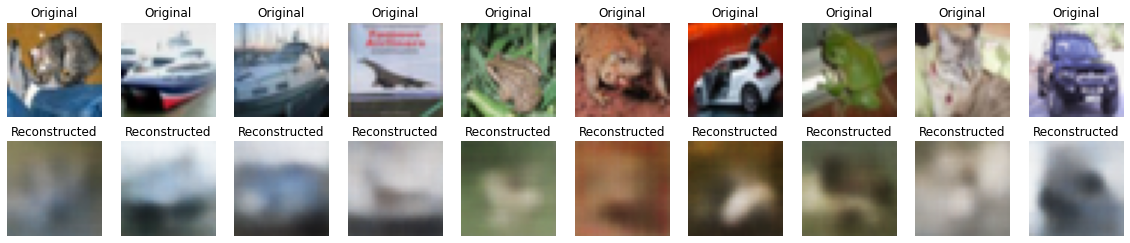

In [26]:
test_images = x_test[:10]
reconstructed = vae(test_images)

plt.figure(figsize=(20, 4))
for i in range(10):
    # Original Image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed Image
    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(reconstructed[i].numpy())
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

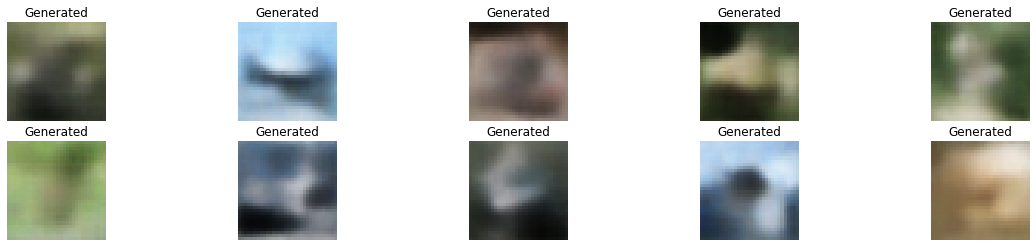

In [27]:
num_images = 10
latent_dim = 64  

# Échantillonnage aléatoire de l'espace latent
random_latent_vectors = tf.random.normal(shape=(num_images, latent_dim))

# Générer des images à partir de l'espace latent
generated_images = vae.decoder(random_latent_vectors)

# Afficher les images générées
plt.figure(figsize=(20, 4))
for i in range(num_images):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy())
    plt.title("Generated")
    plt.axis("off")

plt.show()

79/79 [==============================] - 0s 6ms/step


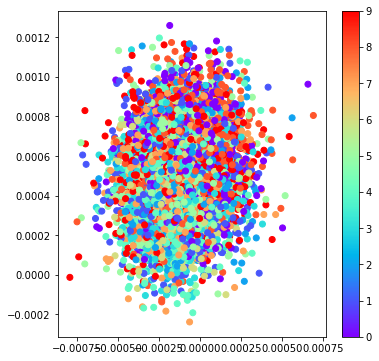

In [50]:
# Convert data to float32
x_test = x_test.astype('float32')

# Data Normalization
x_test /= 255.0

# Predict latent space representation for test data
x_test_encoded = encoder.predict(x_test, batch_size=128)[0]

# Visualizing latent space
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=x_test_label, cmap='rainbow')
plt.colorbar()
plt.show()
